### In this new : 
I am using the dataset with the 1:1's !

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from icecream import ic

In [2]:
data = pd.read_csv('../data/df-time-agg.csv')

# fill the table with the other relevant values 
data['rom_heads'] = data['heads_heads']/data['N_start_heads_up']
data['rom_tails'] = (data['N_start_tails_up']-data['tails_heads'])/data['N_start_tails_up']

# duplicate data : 
data_expanded = pd.concat([
    data.assign(heads_indicator=1),
    data.assign(heads_indicator=0)
])
data_expanded = data_expanded.reset_index(drop=True)

# the function that will select the right r based on the indicator heads indicator : 
def get_r(row):
    if row['heads_indicator'] == 1:
        return row['heads_heads']
    else:
        return row['N_start_tails_up'] - row['tails_heads']
# the function that will select the right m based on the indicator heads indicator : 
def get_m(row):
    if row['heads_indicator'] == 1:
        return row['N_start_heads_up']
    else:
        return row['N_start_tails_up']
    
data_expanded['r'] = data_expanded.apply( get_r, axis=1)
data_expanded['m'] = data_expanded.apply( get_m, axis=1)
data_expanded['rom'] = data_expanded['r'] / data_expanded['m']

print(len(data_expanded))

6990


In [3]:
import statsmodels.api as sm 
from statsmodels.regression import linear_model

WLS_model = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)", data=data_expanded)
result_WLS = WLS_model.fit()

table = sm.stats.anova_lm(result_WLS, typ=2) # Type 2 ANOVA DataFrame
#print(result_WLS.summary())
print(table)

              sum_sq      df         F        PR(>F)
C(person)   1.157068    47.0  4.629221  2.558256e-23
C(coin)     0.364706    43.0  1.594858  8.089770e-03
Residual   36.614816  6885.0       NaN           NaN


In [4]:
WLS_model_0 = linear_model.WLS.from_formula(formula="(rom) ~ 1", data=data_expanded)
WLS_model_1 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)", data=data_expanded) # Best AIC 
WLS_model_2 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)", data=data_expanded) 
WLS_model_3 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)+C(heads_indicator)", data=data_expanded)
WLS_model_4 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)+C(coin)+C(person)/C(coin)", data=data_expanded) # Best LRT
result_WLS_0 = WLS_model_0.fit()
result_WLS_1 = WLS_model_1.fit()
result_WLS_2 = WLS_model_2.fit()
result_WLS_3 = WLS_model_3.fit()
result_WLS_4 = WLS_model_4.fit()
print(f"\nAIC for the WLS_0: {result_WLS_0.aic:.2f}")
print(f"\nAIC for the WLS_1: {result_WLS_1.aic:.2f}")
print(f"\nAIC for the WLS_2: {result_WLS_2.aic:.2f}")
print(f"\nAIC for the WLS_3: {result_WLS_3.aic:.2f}")
print(f"\nAIC for the WLS_4: {result_WLS_4.aic:.2f}")
# lower AIC is better ! we selecti model 2 with coins and persons only 



AIC for the WLS_0: -16514.91

AIC for the WLS_1: -16659.14

AIC for the WLS_2: -16642.01

AIC for the WLS_3: -16640.11

AIC for the WLS_4: -16550.29


In [5]:
# LLR TODO 
#print("first")
#result_WLS_1.compare_lr_test(result_WLS_0, large_sample=False)
#print("second")
#result_WLS_2.compare_lr_test(result_WLS_1, large_sample=False)
#print("third")
#result_WLS_3.compare_lr_test(result_WLS_2, large_sample=False)
print("fourth")
result_WLS_4.compare_lr_test(result_WLS_2, large_sample=False)

fourth


(np.float64(150.28176918101235),
 np.float64(0.03665330311483454),
 np.float64(121.0))

In [6]:
WLS_model_17 = linear_model.WLS.from_formula(formula="(rom) ~ 1+C(person)/C(coin)", data=data_expanded) # Best LRT
result_WLS_17 = WLS_model_17.fit()

result_WLS_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    rom   R-squared:                       0.063
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.173
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           2.29e-19
Time:                        14:45:03   Log-Likelihood:                 8486.1
No. Observations:                6975   AIC:                        -1.655e+04
Df Residuals:                    6764   BIC:                        -1.510e+04
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.4935      0.001    355.303      0.000       0.491       0.496
C(person)[T.AdrianKarami]                                  0.0079      0.008      1.039      0.299      -0.007       0.023
C(person)[T.AndreeaZetea]                                 -0.0044      0.006     -0.697      0.486      -0.017       0.008
C(person)[T.AntonZoubek]                                   0.0059      0.004      1.689      0.091      -0.001       0.013
C(person)[T.ArneJohn]                                     -0.0007      0.007     -0.102      0.919      -0.014       0.012
C(person)[T.BohanFu]                                       0.0008      0.009      0.090      0.928      -0.018       0.019
C(person)[T.ChrisGabrielIslam]                            -0.0017      0.004     -0.382      0.702      -0.010       0.007
C(person)[T.EJ]                                            0.0104      0.008      1.287      0.198      -0.005       0.026
C(person)[T.FelipeFontanaVieira]                          -0.0080      0.005     -1.666      0.096      -0.017       0.001
C(person)[T.FranziskaAssion]                               0.0331      0.007      4.975      0.000       0.020       0.046
C(person)[T.FranziskaNippold]                             -0.0057      0.006     -0.983      0.325      -0.017       0.006
C(person)[T.FrederikAust]                                  0.0026      0.005      0.534      0.593      -0.007       0.012
C(person)[T.HannahArmstrong]                               0.0091      0.012      0.785      0.433      -0.014       0.032
C(person)[T.JanYang]                                       0.0420      0.008      4.939      0.000       0.025       0.059
C(person)[T.JasonNak]                                      0.0023      0.006      0.405      0.686      -0.009       0.013
C(person)[T.JoycePang]                                    -0.0086      0.009     -0.997      0.319      -0.026       0.008
C(person)[T.KarolineH]                                     0.0036      0.006      0.568      0.570      -0.009       0.016
C(person)[T.KatharinaKarnbach]                             0.0051      0.007      0.742      0.458      -0.008       0.019
C(person)[T.KoenDerks]                                     0.0171      0.006      2.875      0.004       0.005       0.029
C(person)[T.MagdaMatetovici]                               0.0221      0.009      2.462      0.014       0.005       0.040
C(person)[T.MalteZoubek]                                   0.0038      0.005      0.800      0.424      -0.006       0.013
C(person)[T.MaraBialas]                                    0.0155      0.007      2.107      0.035       0.001       0.030
C(person

### ANOVA of selected model

In [7]:
table = sm.stats.anova_lm(result_WLS_4, typ=3) # Type 2 ANOVA DataFrame
print(table)


                       sum_sq      df            F         PR(>F)
Intercept           27.240433     1.0  5141.832908   0.000000e+00
C(person)            1.056644    47.0     4.243604   2.627124e-20
C(coin)              0.422935    43.0     1.856562   5.781993e-04
C(person):C(coin)  119.470972  2021.0    11.158352  2.679084e-291
Residual            35.834359  6764.0          NaN            NaN


/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2021, but rank is 205
  warnings.warn('covariance of constraints does not have full '


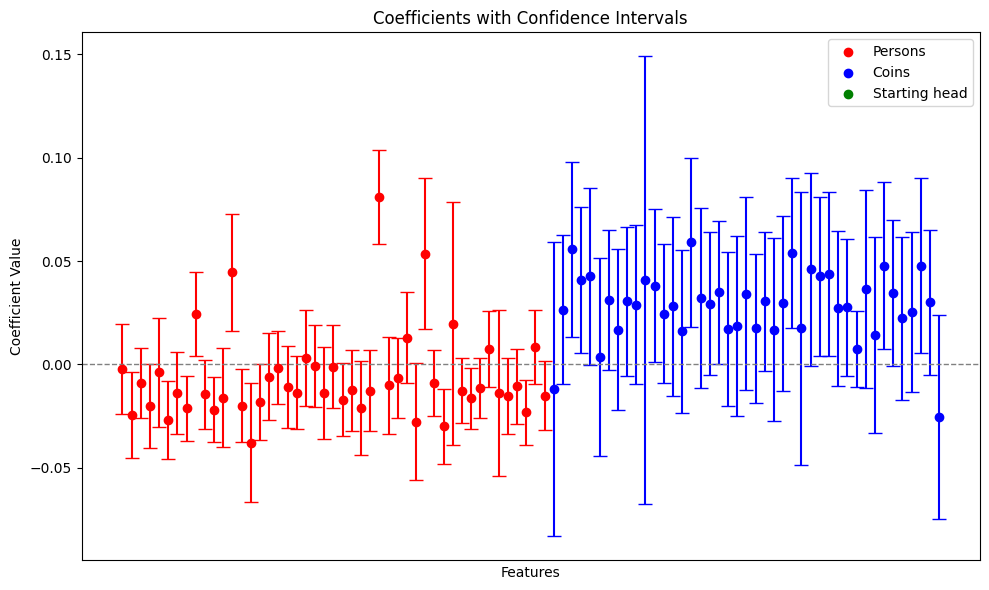

In [8]:
import re

coefficients = result_WLS.params
conf_int = result_WLS.conf_int()

# remove the constant coefficient : 
coefficients = result_WLS.params[1:]  # Exclude the first coefficient
conf_int = result_WLS.conf_int()[1:] 
conf_int_inf= list(conf_int[0])
conf_int_sup= list(conf_int[1])
feature_names = result_WLS.model.exog_names[1:]


# Determine colors based on the feature names
colors = [
    'red' if 'person' in feature else 'blue' if 'coin' in feature else "green"
    for feature in feature_names
]
# Create the plot
plt.figure(figsize=(10, 6))
# Clean the feature names

for i, (feature, coef, color) in enumerate(zip(feature_names, coefficients, colors)):
    plt.errorbar(
        x=i,
        y=coef,
        yerr=[[coef - conf_int_inf[i]], [conf_int_sup[i] - coef]],
        fmt='o',
        ecolor=color,  # Use the determined color for error bars
        color=color,   # Use the determined color for points
        capsize=5
    )

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Create a legend
plt.scatter([], [], color='red', label='Persons')   # Red legend entry
plt.scatter([], [], color='blue', label='Coins')    # Blue legend entry
plt.scatter([], [], color='green', label='Starting head')  # Green legend entry
plt.legend(loc='upper right')

# Add labels and title
plt.xlabel('Features')
plt.xticks([])
plt.ylabel('Coefficient Value')
plt.title('Coefficients with Confidence Intervals')
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

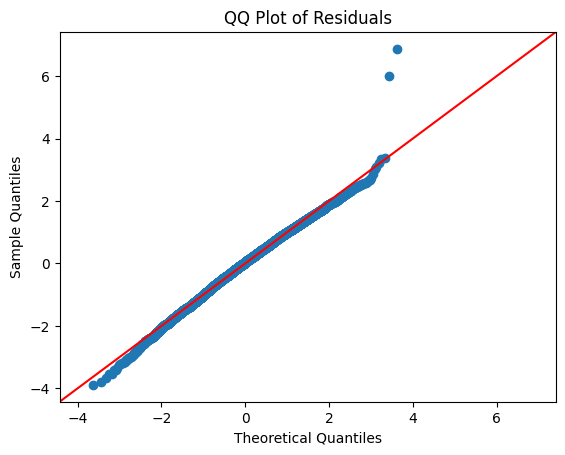

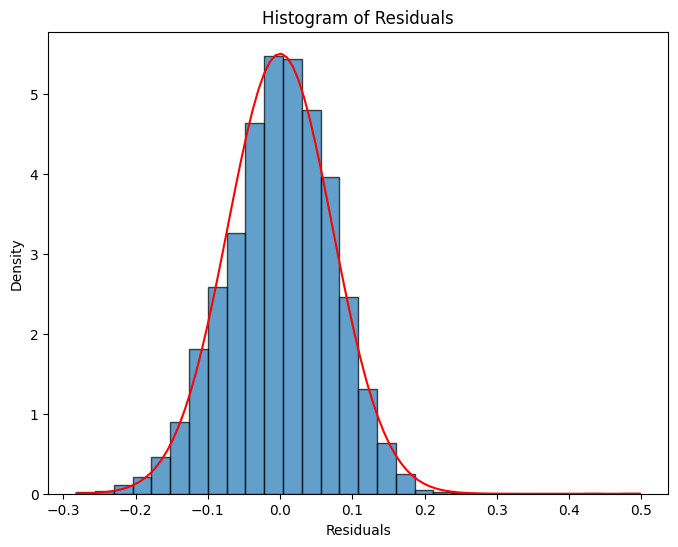

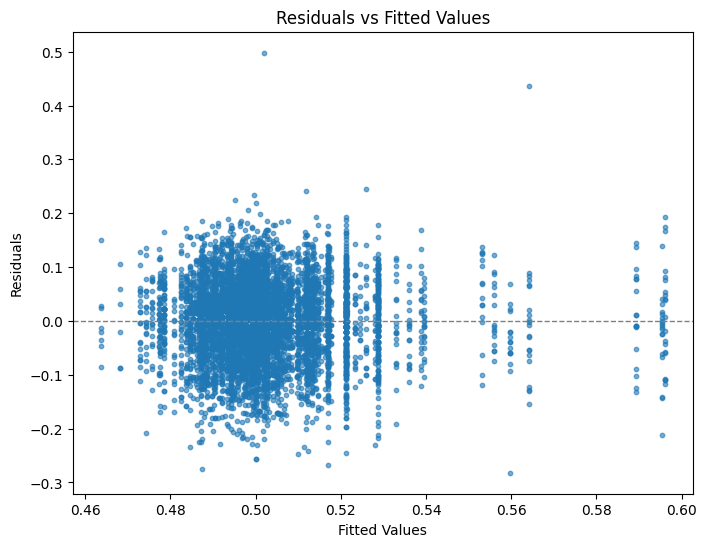

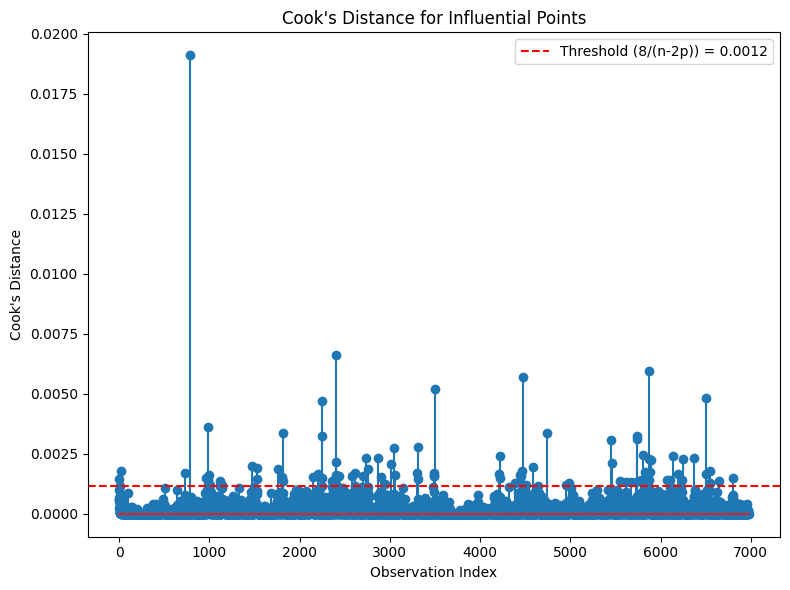

Influential points (index): [   3   22  732  784  962  984  988  989 1000 1006 1124 1139 1470 1528
 1532 1766 1802 1817 1818 2146 2204 2252 2253 2254 2365 2380 2393 2399
 2400 2404 2407 2436 2582 2609 2701 2734 2753 2871 2900 2942 3012 3050
 3054 3305 3308 3309 3490 3493 3495 3500 4213 4217 4220 4387 4437 4446
 4458 4466 4473 4510 4584 4738 4954 4980 5446 5457 5545 5618 5667 5727
 5743 5744 5787 5805 5831 5833 5834 5845 5854 5858 5867 5872 5876 5878
 5899 6073 6105 6137 6191 6238 6251 6365 6505 6507 6549 6551 6647 6801]


In [21]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals = result_WLS.resid # actual values minus the predicted value
fitted_values = result_WLS.fittedvalues # ok predicted values 
standardized_residuals = residuals / np.std(residuals) # standardized residuals
 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals), scale=np.std(residuals)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Scale-Location Plot (Spread of residuals)
'''
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Scale-Location Plot')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.show()
'''

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X = WLS_model.exog  # Design matrix
W = np.diag(WLS_model.weights)  # Diagonal weight matrix
n = X.shape[0]  
p = X.shape[1] 

# matrix H
H = W @ X @ np.linalg.inv(X.T @ W @ X) @ X.T @ W
leverage = np.diag(H)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals = residuals / np.std(residuals)
cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold = 8 / (n - 2 * p)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points = np.where(cooks_d > threshold)[0] # extreme points 
print(f"Influential points (index): {influential_points}")

# COMPLETE MODEL 

In [29]:
WLS_model_complete = linear_model.WLS.from_formula(formula="(rom) ~ 1 + C(person):C(coin)", data=data_expanded)
result_WLS_complete = WLS_model_complete.fit()
table_complete = sm.stats.anova_lm(result_WLS_complete, typ=2) # Type 2 ANOVA DataFrame
print(f"\nAIC for the WLS of complete model: {result_WLS_complete.aic:.2f}")
print(table_complete)


AIC for the WLS of complete model: -16550.29
                         sum_sq      df            F  PR(>F)
C(person):C(coin)  17668.415762  2111.0  1579.840826     0.0
Residual              35.834359  6764.0          NaN     NaN


/Users/rayan/Documents/GitHub/reg-project/venv/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2111, but rank is 211
  warnings.warn('covariance of constraints does not have full '


<Figure size 800x600 with 0 Axes>

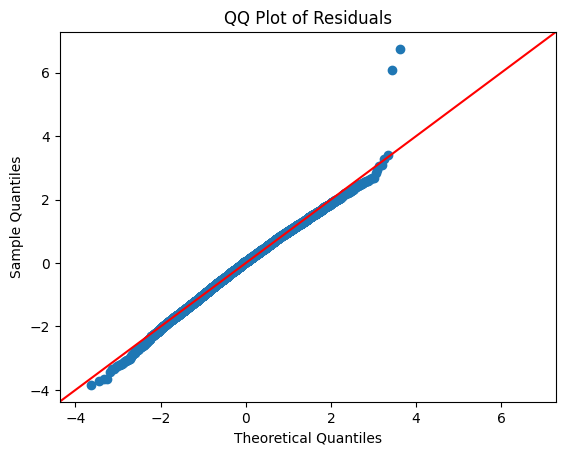

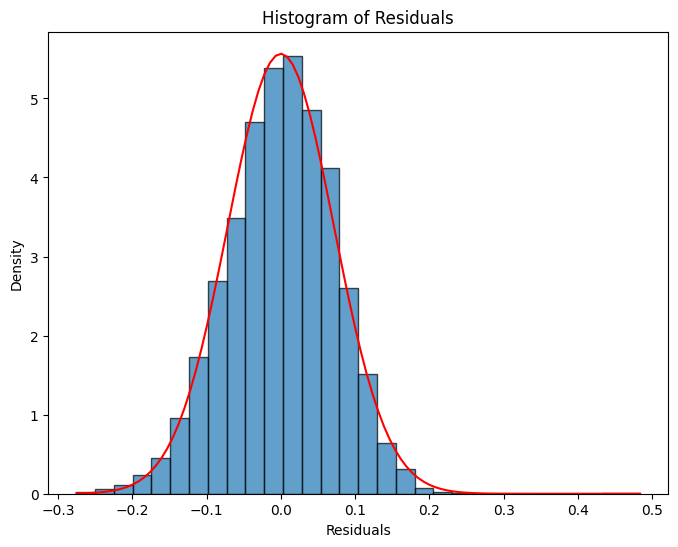

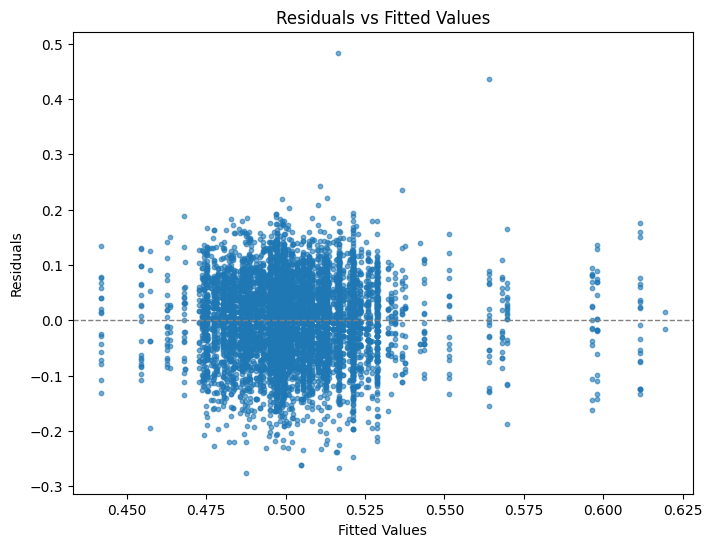

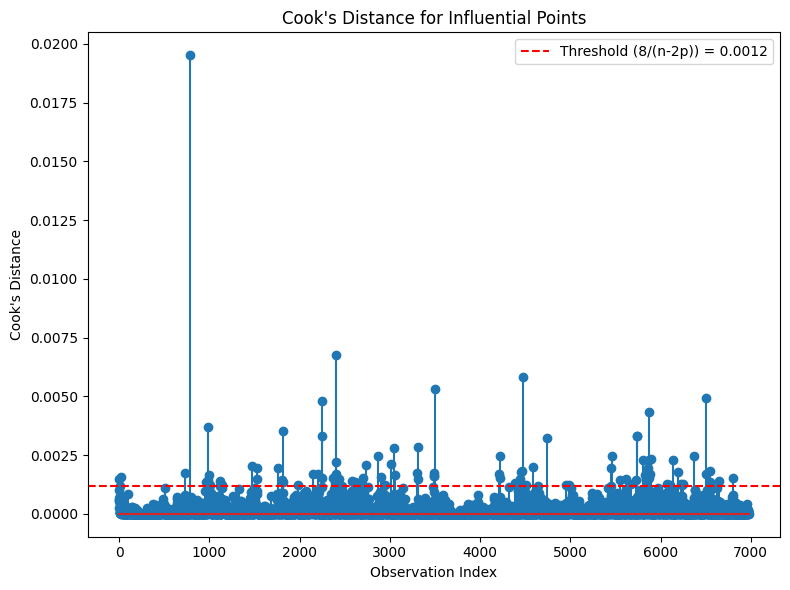

Influential points (index): [ 784  988 1817 2252 2253 2400 3500 4473 4738 5743 5744 5867 6507]


In [26]:
import scipy.stats as stats

# Extract residuals and fitted values
residuals_complete = result_WLS_complete.resid # actual values minus the predicted value
fitted_values_complete = result_WLS_complete.fittedvalues # ok predicted values 
standardized_residuals_complete = residuals_complete / np.std(residuals_complete) # standardized residuals
 

# QQ Plot (Normality of residuals)
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_complete, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of Residuals (Check for normality)
plt.figure(figsize=(8, 6))
plt.hist(residuals_complete, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
x = np.linspace(residuals_complete.min(), residuals_complete.max(), 100)
plt.plot(x, stats.norm.pdf(x, loc=np.mean(residuals_complete), scale=np.std(residuals_complete)), color='red')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values_complete, residuals_complete, alpha=0.6,s=10)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# ----------------------------------------------------------------------------------------------------
# COOK'S MEASURE : 
# ----------------------------------------------------------------------------------------------------
# Extract model data
X_complete = WLS_model_complete.exog  # Design matrix
W_complete = np.diag(WLS_model_complete.weights)  # Diagonal weight matrix
n_complete = X_complete.shape[0]  
p_complete = X_complete.shape[1] 

# matrix H
H = W @ X @ np.linalg.inv(X.T @ W @ X) @ X.T @ W
leverage_complete = np.diag(H)  # diagonal of H, the hjj's in the slides

# Cook distance
standardized_residuals_complete = residuals_complete / np.std(residuals_complete)
cooks_d_complete= (standardized_residuals_complete**2 * leverage_complete) / (p * (1 - leverage_complete))
# check :::: cooks_d = (standardized_residuals**2 * leverage) / (p * (1 - leverage)**2)

# Threshold for Cook's Distance
threshold_complete = 8 / (n_complete - 2 * p_complete)

# Plot Cook's Distance
plt.figure(figsize=(8, 6))
plt.stem(np.arange(len(cooks_d_complete)), cooks_d_complete)  
plt.title("Cook's Distance for Influential Points")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (8/(n-2p)) = {threshold:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

influential_points_complete = np.where(cooks_d_complete > threshold_complete)[0] # extreme points 
print(f"Influential points (index): {influential_points_complete}")